In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt, log10, ceil, pi
from copy import deepcopy

### Loading data from pickle file

In [47]:
df_out = pd.read_pickle('../results/organizations_profiles.bin')

### Pre analysis filters

* Filter out banks without any transfers: functional banks
* Replace Null values with zeroes for functional banks (might not be a good idea)
* Filter out inactive banks

In [48]:
# convert transfers from seconds to minutes
df_out['amount_tot'] = -1*df_out['amount_tot']/3600
df_out['amount_per_member'] = -1*df_out['amount_per_member']/3600

In [49]:
df_functional = df_out[(df_out.n_transf_tot > 0.0)]
df_active = df_functional[(df_functional.pc_active > 0.0)]
df_func_zeroes = df_functional.fillna(0)

In [50]:
variables_desired = ['n_members',
                       'n_active_members',
                       'avg_delay',
                       'n_transf_tot',
                       'amount_tot',
                       'ntransf_per_member',
                       'amount_per_member',
                       'pc_active',
                       'avg_seniority',
                       'density',
                       'avg_centrality',
                       'n_popular_members']

In [6]:
def plot_histograms(df, variables_histogram):
    rows = ceil(len(variables_histogram)/3)
    fig, ax = plt.subplots(rows, 3, figsize=(14, ceil(3.5*rows)))
    ax = ax.ravel() 
    for i, key in enumerate(variables_histogram):
        ax[i].hist(df[key], bins=20, color='#298ba1')
        ax[i].set_title(key)
    fig.savefig('01.png')

In [23]:
def abslog(x):
    if x > 1:
        return log10(x)
    elif x < -1:
        return -log10(-x)
    else:
        return 0

In [19]:
log_normal_vars = ['n_members',
                       'n_active_members',
                       'n_transf_tot',
                       'amount_tot',
                       'ntransf_per_member',
                       'amount_per_member']
to_sqrt_vars = ['avg_delay', 'pc_active']
rest_vars = list(set(variables_desired).difference(set(log_normal_vars+to_sqrt_vars)))
sqrt_vars = ['sqrt_'+v for v in to_sqrt_vars]
abslog_vars = ['abslog_'+v for v in log_normal_vars]
mixed_vars = sqrt_vars + abslog_vars + rest_vars

In [51]:
df_mixed = pd.DataFrame()

for var in log_normal_vars:
    print(var)
    df_mixed['abslog_'+var] = df_func_zeroes[var].apply(lambda x: abslog(x)) # this is wrong

for var in to_sqrt_vars:
    print(var)
    df_mixed['sqrt_'+var] = df_func_zeroes[var].apply(lambda x: sqrt(abs(x))) # this is wrong
    
for var in rest_vars:
    df_mixed[var] = df_func_zeroes[var]

n_members
n_active_members
n_transf_tot
amount_tot
ntransf_per_member
amount_per_member
avg_delay
pc_active


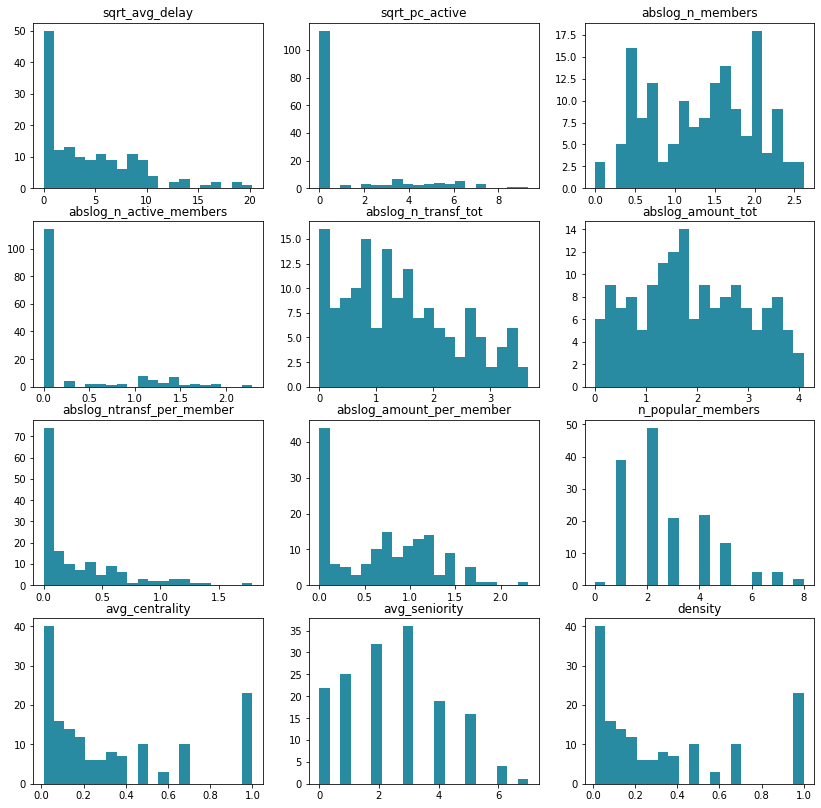

In [52]:
plot_histograms(df_mixed, mixed_vars)

## Clustering banks

In [26]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

First use PCA to reduce dimensionality to 3

In [31]:
def use_pca(df, dim=3):
    X = df_mixed.values
    pca = PCA(n_components=dim, svd_solver='full')
    pca.fit(X)
    X_trans = pca.transform(X)

    fig, ax = plt.subplots(dim, 1, figsize=(7, 12))
    ax = ax.ravel() 

    ax[0].scatter(X_trans[:, 0], X_trans[:, 1])
    ax[1].scatter(X_trans[:, 1], X_trans[:, 2])
    ax[2].scatter(X_trans[:, 0], X_trans[:, 2])
    return X_trans

def cluster_three_d(X, n_clusters=3):
    y_pred = KMeans(n_clusters=n_clusters).fit_predict(X)
    fig, ax = plt.subplots(3, 1, figsize=(7, 12))
    ax = ax.ravel() 

    ax[0].scatter(X[:, 0], X[:, 1], c=y_pred)
    ax[1].scatter(X[:, 1], X[:, 2], c=y_pred)
    ax[2].scatter(X[:, 0], X[:, 2], c=y_pred)
    return y_pred

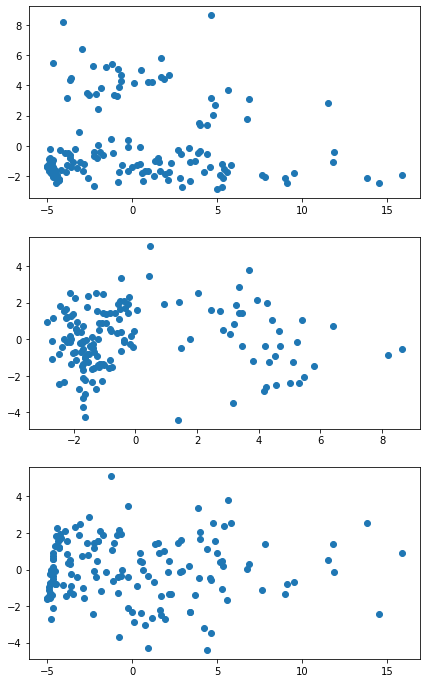

In [53]:
X_new = use_pca(df_mixed)

## Use Kmeans to cluster
First for 4 clusters, then for 3 clusters

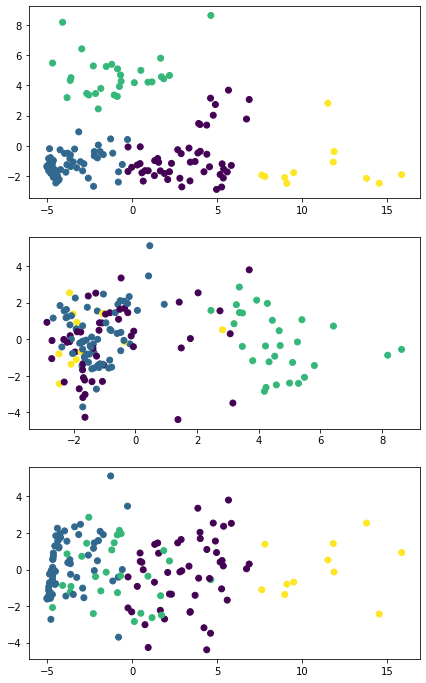

In [60]:
y_pred_4clusters = cluster_three_d(X_new, n_clusters=4)

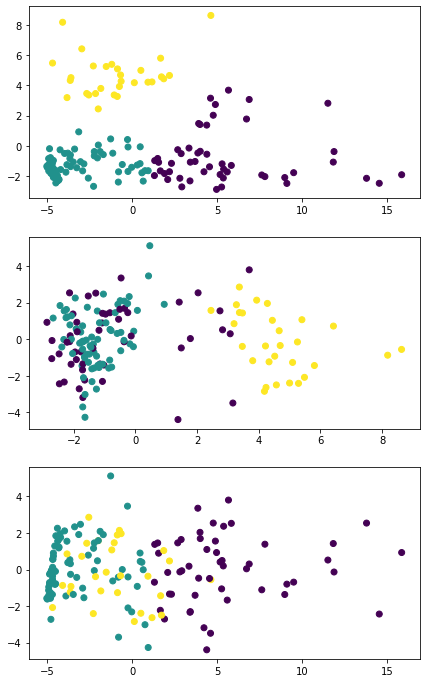

In [61]:
y_pred_3clusters = cluster_three_d(X_new, n_clusters=3)

## Checking the resulting clusters
First for 3 clusters

In [62]:
df_mixed['cluster'] = y_pred_3clusters
df_mixed.groupby("cluster").agg(['mean','median'])

abslog_n_members           abslog_n_active_members            \
                    mean    median                    mean    median   
cluster                                                                
0               1.669338  1.643340                0.219902  0.000000   
1               0.985288  0.845098                0.007922  0.000000   
2               1.814274  1.968483                1.220237  1.146128   

        abslog_n_transf_tot           abslog_amount_tot            \
                       mean    median              mean    median   
cluster                                                             
0                  1.573278  1.392309          2.022450  1.992632   
1                  0.978233  0.903090          1.472519  1.439261   
2                  2.349340  2.648360          2.885609  3.266436   

        abslog_ntransf_per_member            ... sqrt_pc_active            \
                             mean    median  ...           mean    median   
cluster                                      ...                            
0                        0.221203  0.020696  ...       0.652572  0.000000   
1                        0.182028  0.000000  ...       0.030129  0.000000   
2                        0.583594  0.568202  ...       5.309254  5.374942   

        n_popular_members        avg_centrality           avg_seniority  \
                     mean median           mean    median          mean   
cluster                                                                   
0                2.980000    2.5       0.228164  0.170586      3.200000   
1                2.868421    2.0       0.490150  0.500000      2.368421   
2                1.862069    2.0       0.108157  0.041080      1.517241   

                 density            
        median      mean    median  
cluster                             
0          3.0  0.228164  0.170586  
1          2.0  0.490150  0.500000  
2          1.0  0.108157  0.041080  

[3 rows x 24 columns]

In [96]:
df_check = df_func_zeroes[variables_desired]

df_check['cluster'] = y_pred_3clusters
df_check.groupby("cluster").agg(['mean','median','std']).T

/usr/lib/python3/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


cluster                              0            1            2
n_members          mean      84.160000    23.315789   100.344828
                   median    44.000000     7.000000    93.000000
                   std       95.728860    37.199359    76.571291
n_active_members   mean       3.960000     0.052632    27.413793
                   median     0.000000     0.000000    14.000000
                   std       11.614488     0.322273    36.926101
avg_delay          mean     110.816000     5.047368    16.148276
                   median    81.550000     0.100000     9.800000
                   std       88.073495     8.693468    18.219605
n_transf_tot       mean     320.280000    68.644737   744.482759
                   median    25.000000     8.000000   445.000000
                   std      821.227156   308.222721   926.339556
amount_tot         mean     907.973989   275.551623  2398.023851
                   median   102.125000    27.500000  1846.866667
                   std     2173.326918  1051.905095  2449.786505
ntransf_per_member mean       2.102000     2.425000     5.758621
                   median     1.050000     1.000000     3.700000
                   std        3.098090     7.437600     5.596269
amount_per_member  mean       7.052734     9.140174    20.316542
                   median     3.889569     4.088083    13.384278
                   std        8.127923    24.525864    17.426248
pc_active          mean       2.282200     0.034737    30.911379
                   median     0.000000     0.000000    28.890000
                   std        5.288173     0.215713    19.048644
avg_seniority      mean       3.200000     2.368421     1.517241
                   median     3.000000     2.000000     1.000000
                   std        1.484615     1.680017     1.326130
density            mean       0.228164     0.490150     0.108157
                   median     0.170586     0.500000     0.041080
                   std        0.239234     0.359043     0.188585
avg_centrality     mean       0.228164     0.490150     0.108157
                   median     0.170586     0.500000     0.041080
                   std        0.239234     0.359043     0.188585
n_popular_members  mean       2.980000     2.868421     1.862069
                   median     2.500000     2.000000     2.000000
                   std        1.953438     1.517385     1.186957

Then for 4 clusters

In [64]:
df_check['cluster'] = y_pred_4clusters
df_check.groupby("cluster").agg(['mean','median','std']).T

/usr/lib/python3/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


cluster                              0            1            2            3
n_members          mean      68.346939    23.636364   100.344828    97.363636
                   median    41.000000     6.000000    93.000000    35.000000
                   std       84.216623    39.531735    76.571291   116.714414
n_active_members   mean       3.469388     0.060606    27.413793     2.545455
                   median     0.000000     0.000000    14.000000     0.000000
                   std       11.199148     0.345467    36.926101     8.442318
avg_delay          mean      61.587755     2.063636    16.148276   251.854545
                   median    63.800000     0.000000     9.800000   244.900000
                   std       28.566659     3.972933    18.219605    88.107200
n_transf_tot       mean     271.632653    74.030303   744.482759   275.909091
                   median    34.000000     6.500000   445.000000     9.000000
                   std      777.518159   330.575301   926.339556   687.246747
amount_tot         mean     792.090465   292.670051  2398.023851   746.542424
                   median   129.750000    21.000000  1846.866667    35.000000
                   std     2052.139344  1126.164336  2449.786505  1852.547686
ntransf_per_member mean       2.173469     2.509091     5.758621     1.572727
                   median     1.300000     1.000000     3.700000     0.400000
                   std        2.847058     7.969378     5.596269     3.090660
amount_per_member  mean       7.511805     9.390545    20.316542     5.403232
                   median     4.070417     3.916667    13.384278     3.615528
                   std        7.786951    26.207663    17.426248     8.519829
pc_active          mean       2.059184     0.040000    30.911379     1.200909
                   median     0.000000     0.000000    28.890000     0.000000
                   std        5.099878     0.231251    19.048644     3.982965
avg_seniority      mean       2.795918     2.454545     1.517241     3.727273
                   median     3.000000     2.000000     1.000000     4.000000
                   std        1.658056     1.647206     1.326130     1.272078
density            mean       0.228295     0.519144     0.108157     0.291786
                   median     0.163636     0.500000     0.041080     0.254545
                   std        0.222471     0.369860     0.188585     0.280902
avg_centrality     mean       0.228295     0.519144     0.108157     0.291786
                   median     0.163636     0.500000     0.041080     0.254545
                   std        0.222471     0.369860     0.188585     0.280902
n_popular_members  mean       3.285714     2.696970     1.862069     2.545455
                   median     3.000000     2.000000     2.000000     2.000000
                   std        2.051422     1.391952     1.186957     1.439697

Normalize the values to be between 0 and 1, depending on their min max

In [108]:
df_check = df_func_zeroes[variables_desired]
df_check['cluster'] = y_pred_3clusters

df_normalized = pd.DataFrame()
for v in df_check.columns.to_list():
    if v != 'cluster':
        if v in log_normal_vars+['avg_delay']:
            df_normalized[v] = df_check[v].apply(lambda x: log10(1+x))
            df_normalized[v] = (df_normalized[v]-df_normalized[v].min())/(df_normalized[v].max()-df_normalized[v].min())
        else:
            df_normalized[v] = (df_check[v]-df_check[v].min())/(df_check[v].max()-df_check[v].min())

df_normalized['cluster'] = y_pred_3clusters

/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [134]:
means = df_normalized.groupby("cluster").median()
df = means.reset_index()
df

,cluster,n_members,n_active_members,avg_delay,n_transf_tot,amount_tot,ntransf_per_member,amount_per_member,pc_active,avg_seniority,density,avg_centrality,n_popular_members
0,0,0.631427,0.000000,0.733029,0.329739,0.486706,0.173792,0.298849,0.000000,0.428571,0.161948,0.161948,0.3125
1,1,0.344948,0.000000,0.015141,0.194265,0.354045,0.167883,0.306315,0.000000,0.285714,0.494792,0.494792,0.2500
2,2,0.753664,0.513569,0.395222,0.698384,0.797187,0.374826,0.502029,0.332069,0.142857,0.031093,0.031093,0.2500


Draw the means in a radar graph

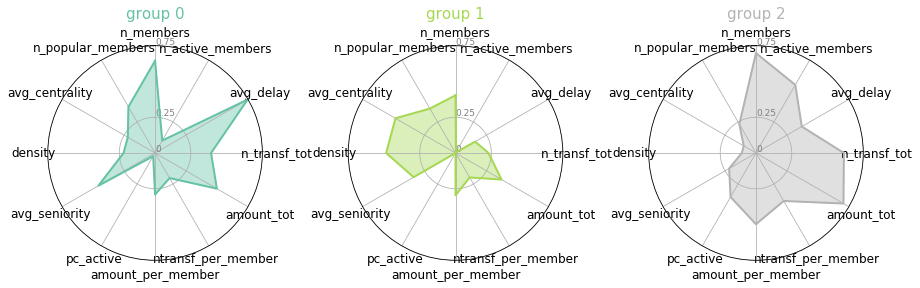

In [132]:
def make_spider(row, no_cluster, title, color):
 
    # number of variable
    categories=list(df)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(1,no_cluster,row+1, polar=True, )

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='black', size=12)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0,0.25,0.75], ["0","0.25","0.75"], color="grey", size=9)
    plt.ylim(0,0.75)

    # Ind1
    values=df.loc[row].drop('cluster').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    plt.title(title, size=15, color=color, y=1.1)

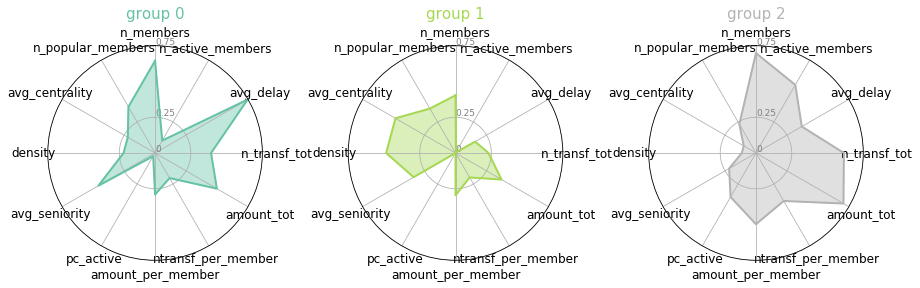

In [135]:
means = df_normalized.groupby("cluster").mean()
df = means.reset_index()    

# ------- PART 2: Apply to all individuals
# initialize the figure
#my_dpi=96
#plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
plt.figure(figsize=(20,10))

# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(df.index))
 
# Loop to plot
for row in range(0, len(df.index)):
    make_spider(row=row, no_cluster=4, title='group '+str(df['cluster'][row]), color=my_palette(row))
plt.subplots_adjust(wspace=0.4)
plt.savefig('cluster_means.png')

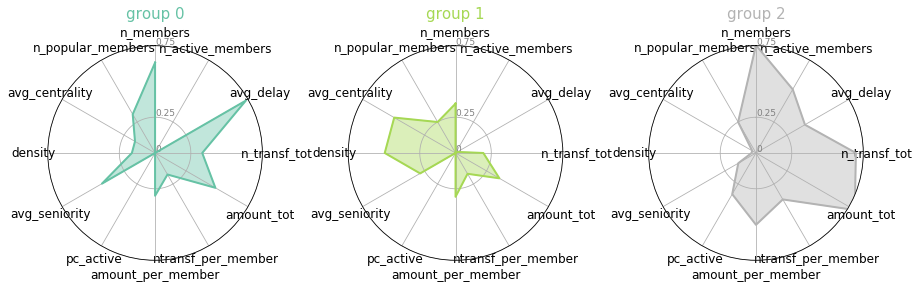

In [136]:
means = df_normalized.groupby("cluster").median()
df = means.reset_index()    

# ------- PART 2: Apply to all individuals
# initialize the figure
#my_dpi=96
#plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
plt.figure(figsize=(20,10))

# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(df.index))
 
# Loop to plot
for row in range(0, len(df.index)):
    make_spider(row=row, no_cluster=4, title='group '+str(df['cluster'][row]), color=my_palette(row))
plt.subplots_adjust(wspace=0.4)
plt.savefig('cluster_media.png')